In [2]:
STOCK_SIZE = 100

In [3]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

# Simulated annealing

In [4]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [5]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [6]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    
    for order in orders:
        
        order_cut = False
        
        for j, leftover in enumerate(leftovers):
            if order <= leftover:
                leftovers[j] -= order
                order_cut = True
                break
        
        if not order_cut:
            num_stocks += 1
            leftovers.append(STOCK_SIZE - order)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [7]:
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp

In [8]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_alpha(initial_temp: float, min_temp: float, num_iters: int) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [9]:
from typing import Callable

In [10]:
def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 1,
                        alpha: float = None,
                        max_iters: int = 5000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 2,
                        sum_best_values: list[int] = None,
                        sum_num_stocks: list[int] = None,
                        sum_value_perc_improvement: list[float] = None,
                        sum_num_stocks_perc_improvement: list[float] = None
                        ) -> tuple[list[int], int, int]:
    if alpha is None:
        alpha = calc_alpha(initial_temp, min_temp, max_iters)
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
        
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
            value = new_value
            solution = deepcopy(new_solution)
            stocks_used = new_stocks_used
            accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
                    
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
          
# -------------------------------------------------------------------------------------

    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    if sum_best_values is not None:
        if len(PLT_VALUES) < len(sum_best_values):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_best_values) - len(PLT_VALUES)))
        
        for i in range(len(sum_best_values)):
            sum_best_values[i] = sum_best_values[i] + PLT_VALUES[i]
        
    if sum_num_stocks is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks) - len(PLT_STOCKS_USED)))
        for i in range(len(sum_num_stocks)):
            sum_num_stocks[i] = sum_num_stocks[i] + PLT_STOCKS_USED[i]
            
    if sum_value_perc_improvement is not None:
        if len(PLT_VALUES) < len(sum_value_perc_improvement):
            PLT_VALUES.extend([PLT_VALUES[-1]] * (len(sum_value_perc_improvement) - len(PLT_VALUES)))
        
        initial_val = PLT_VALUES[0]
        perc_improvement = [((initial_val - val) / initial_val * 100) for val in PLT_VALUES]
        
        for i in range(len(sum_value_perc_improvement)):
            sum_value_perc_improvement[i] = sum_value_perc_improvement[i] + perc_improvement[i]
            
    if sum_num_stocks_perc_improvement is not None:
        if len(PLT_STOCKS_USED) < len(sum_num_stocks_perc_improvement):
            PLT_STOCKS_USED.extend([PLT_STOCKS_USED[-1]] * (len(sum_num_stocks_perc_improvement) - len(PLT_STOCKS_USED)))
    
        initial_num_stocks = PLT_STOCKS_USED[0]
        perc_improvement = [((initial_num_stocks - num_stocks) / initial_num_stocks * 100) for num_stocks in PLT_STOCKS_USED]
        
        for i in range(len(sum_num_stocks_perc_improvement)):
            sum_num_stocks_perc_improvement[i] = sum_num_stocks_perc_improvement[i] + perc_improvement[i]
        
    return best_solution, best_value, best_stocks_used

# Genetic algorithm

In [34]:
POPULATION_SIZE = 50
NUM_ITERS = 200
ELITISM_SIZE = 6
MUTATION_PROB = 0.02
CROSSOVER_PROB = 0.9
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]
MC_OPTION = 'FIXED'

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(self.code)

In [35]:
def ga(orders:    list[int],
       selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
       crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
       mutation:  Callable[[Individual], None] = mutation_swap,
       plot: bool = False,
       POPULATION_SIZE: int = 100,
       MC_OPTION: str = 'FIXED',
       CROSSOVER_PROB: float = 0.85,
       MUTATION_PROB: float = 0.07,
       NUM_ITERS: int = 100,
       ELITISM_SIZE: int = 4,
       sum_best_solutions: list[int] = None,
       sum_num_stocks: list[int] = None
      ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
        if MC_OPTION == 'DHM/ILC':
            MUTATION_PROB = 1 - (it / (NUM_ITERS - 1))
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB

            CROSSOVER_PROB = it / (NUM_ITERS - 1)
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        elif MC_OPTION == 'ILM/DHC':
            MUTATION_PROB = it / (NUM_ITERS - 1)
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB
            
            CROSSOVER_PROB = 1 - (it / (NUM_ITERS - 1))
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1]) 
                                       
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    if sum_best_solutions is not None:
        for i in range(len(sum_best_solutions)):
            sum_best_solutions[i] = sum_best_solutions[i] + PLT_VALUES[i]
        
    if sum_num_stocks is not None:
        for i in range(len(sum_num_stocks)):
            sum_num_stocks[i] = sum_num_stocks[i] + PLT_STOCKS_USED[i]
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

### Selection

In [23]:
def tournament_selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

### Crossover

In [27]:
def generalized_order_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    chosen1 = [(parent1.code[i], ind_array1[i]) for i in range(pos1, pos2)]
    chosen2 = [(parent2.code[i], ind_array2[i]) for i in range(pos1, pos2)]

    result1 = []
    result2 = []

    for i,num in enumerate(parent2.code):
        if (num, ind_array2[i]) == chosen1[0]:
            result1.extend([x[0] for x in chosen1])
            continue
        if (num, ind_array2[i]) in chosen1:
            continue
        result1.append(num)
        
    for i,num in enumerate(parent1.code):
        if (num, ind_array1[i]) == chosen2[0]:
            result2.extend([x[0] for x in chosen2])
            continue
        if (num, ind_array1[i]) in chosen2:
            continue
        result2.append(num)
       
    child1.code = result1
    child2.code = result2

### Mutation

In [30]:
def mutation_swap(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))

    tmp = instance.code[pos1]
    instance.code[pos1] = instance.code[pos2]
    instance.code[pos2] = tmp

## Genetic algorithm + Simulated annealing

#### GA + SA on every individual in every generation

In [39]:
def ga_plus_sa(orders:    list[int],
               selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
               crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
               mutation:  Callable[[Individual], None] = mutation_swap,
               plot: bool = False,
               POPULATION_SIZE: int = 100,
               CROSSOVER_PROB: float = 0.85,
               MUTATION_PROB: float = 0.07,
               NUM_ITERS: int = 100,
               ELITISM_SIZE: int = 4,
               ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        print(f'Generation {it+1}/{NUM_ITERS}  ', end='\r')
        
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1])
                
            solution, value, num_stocks = simulated_annealing(new_population[i].code,
                                                              max_iters = 1000
                                                             )
            new_population[i].code[:] = solution[:]
            new_population[i].fitness = value
            new_population[i].num_stocks = num_stocks
            
            solution, value, num_stocks = simulated_annealing(new_population[i+1].code,
                                                              max_iters = 1000
                                                             )
            new_population[i+1].code[:] = solution[:]
            new_population[i+1].fitness = value
            new_population[i+1].num_stocks = num_stocks

        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

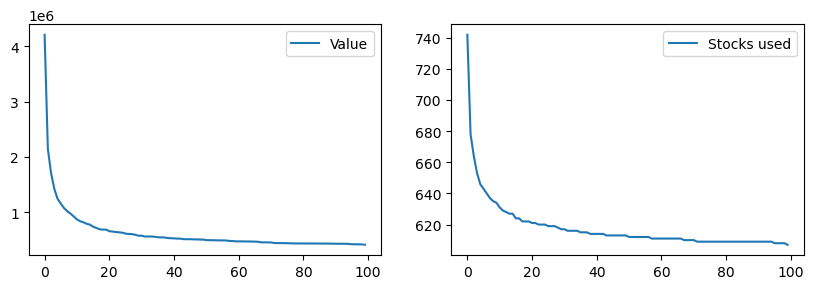

412653 607


In [40]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = ga_plus_sa(orders, plot=True)
print(value, num_stocks)

#### GA + SA on the best individual in every generation

In [34]:
def ga_plus_sa_2(orders:    list[int],
                 selection: Callable[[list[Individual], Individual], Individual] = tournament_selection,
                 crossover: Callable[[Individual, Individual, Individual, Individual], None] = generalized_order_crossover,
                 mutation:  Callable[[Individual], None] = mutation_swap,
                 plot: bool = False,
                 POPULATION_SIZE: int = 100,
                 CROSSOVER_PROB: float = 0.85,
                 MUTATION_PROB: float = 0.07,
                 NUM_ITERS: int = 100,
                 ELITISM_SIZE: int = 4,
                 ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        print(f'Generation {it+1}/{NUM_ITERS}  ', end='\r')
        
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        solution, value, num_stocks = simulated_annealing(new_population[0].code,
                                                          max_iters = 1000
                                                          )
        new_population[0].code[:] = solution[:]
        new_population[0].fitness = value
        new_population[0].num_stocks = num_stocks
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1])    
                
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)

        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
        
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

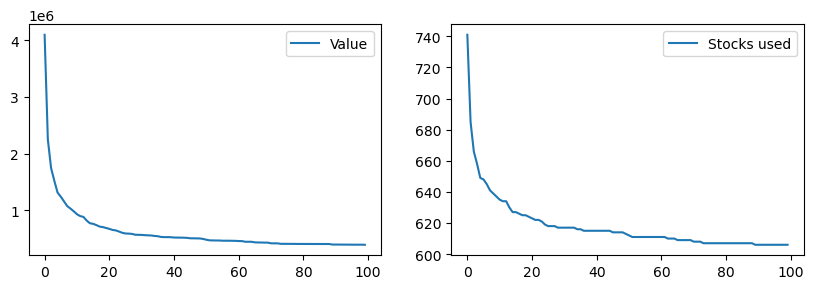

392029 606


In [42]:
orders = read_instance('test_instances/test_instance_20.csp')
_, value, num_stocks = ga_plus_sa_2(orders, plot=True)
print(value, num_stocks)

#### GA + SA on the best GA solution

In [51]:
def ga_plus_sa_3(orders):
    solution, value, num_stocks = ga(orders, plot=True)
    solution, value, num_stocks = simulated_annealing(solution, plot=True, max_iters=10000)
    print(value, num_stocks)

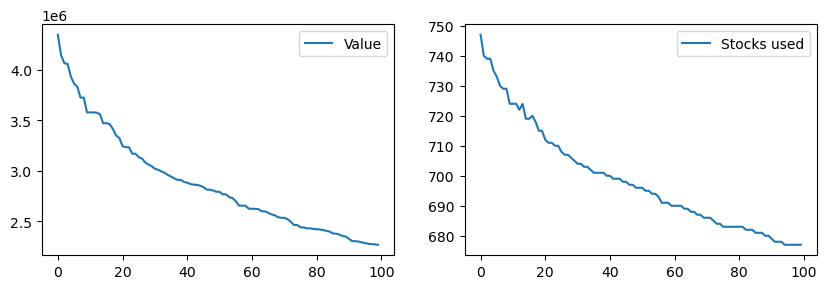

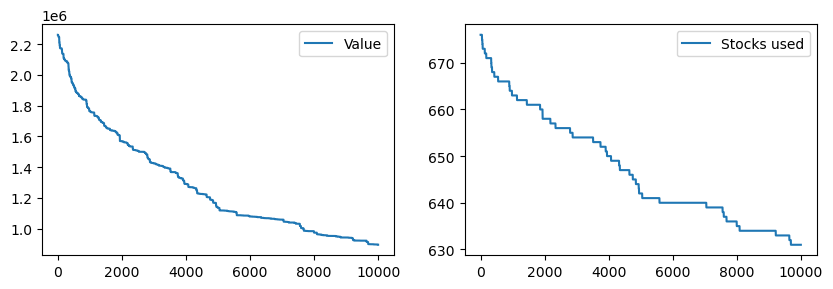

894335 631


In [52]:
orders = read_instance('test_instances/test_instance_20.csp')
ga_plus_sa_3(orders)